In [ ]:
import torch
import torch.nn.functional as Func
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Building Dataset

In [ ]:
X = np.expand_dims(np.linspace(-10, 10, num=200, dtype=np.float32), -1)
#y = np.cos(X)+np.sqrt(X)
y = np.cos(X)+5

In [ ]:
plt.plot(X,y)

In [ ]:
class Regressor(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Regressor, self).__init__()
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
    def forward(self,x):
        x = Func.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [ ]:
model = Regressor(200,300,200)
model

In [ ]:
## Regressor parameters
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(),learning_rate)
loss_function = torch.nn.MSELoss()

In [ ]:
X_inp = torch.from_numpy(X)
print(X_inp.requires_grad)
print(X_inp.shape)
X_inp[0:10]

In [ ]:
X_inp.view(1,-1).shape

In [ ]:
y_inp = torch.from_numpy(y)
y_inp.requires_grad

In [ ]:
## Training
for t in range(200):
    pred = model(Variable(X_inp.view(1,-1)))
    loss = loss_function(pred, y_inp.view(1,-1))
        
    optimizer.step()
    optimizer.zero_grad()
    loss.backward()

    if t %50 ==0:
        plt.cla()
        plt.scatter(X_inp.data.numpy(), y_inp.data.numpy())
        plt.plot(X_inp.data.numpy(), pred.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        #plt.pause(0.1)
plt.ioff()
plt.show()

## Adding Gaussian Noise

In [ ]:
X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 20, std = 150)
y = x**3 + noise

In [ ]:
plt.plot(x.data.numpy(), y.data.numpy())

In [ ]:
x.size()[0], y.size()[0]

In [ ]:
model_2 = Regressor(x.size()[0], 400, y.size()[0])
model_2

In [ ]:
learning_rate = 0.0001
optimizer = optim.SGD(model_2.parameters(),learning_rate)
loss_function = torch.nn.MSELoss()
#loss_function = torch.nn.NLLLoss()

In [ ]:
y.view(1,-1).size()

In [ ]:
model_2.forward(Variable(x.view(1,-1)))

In [ ]:
num_iter = 300
    
for i in range(num_iter):
    #model_2.zero_grad()
    preds = model_2(Variable(x.view(1,-1)))
    loss = loss_function(preds, y.view(1,-1))
    
    optimizer.step()
    optimizer.zero_grad()
    loss.backward()

    if i %50 ==0:
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
plt.ioff()
plt.show()

## Uncertainty in Deep Ensembles

- What’s a “good” uncertainty estimate?  
    – Calibration  
    – Higher uncertainty on out-of-distribution examples  

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 20, std = 100)
y = x**3 + noise
plt.plot(x.data.numpy(), y.data.numpy())

In [ ]:
class GaussianRegressor(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, sizes, min_var = 1e-6):
        super(GaussianRegressor, self).__init__()
        self.h = torch.zeros(n_input,sizes)
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.sizes = sizes
        self.layers = [self.hidden for i in range(sizes)]
        self.num_layers = sizes
    def forward(self,x):
        h = x
        output = []
        for i in range(self.num_layers):
            out = Func.relu(self.hidden(x))
            out = self.predict(out)
            output.append(out)
        mean, raw_var  = output
        var = Func.softplus(raw_var) + 1e-6
        return mean, var

In [ ]:
modelito = GaussianRegressor(x.size()[0], 200, y.size()[0], sizes = 2)
modelito 

In [ ]:
learning_rate = 0.00001
optimizer = optim.SGD(modelito.parameters(),learning_rate)
loss_function = torch.nn.MSELoss()
#loss_function = torch.nn.NLLLoss(weight=None)

In [ ]:
from __future__ import print_function

num_iter = 200
for i in range(num_iter):
    preds, var = modelito(Variable(x.view(1,-1)))
    loss = loss_function(preds, y.view(1,-1))
    print("Loss {}".format(loss))
    optimizer.step()
    optimizer.zero_grad()
    loss.register_hook(print)
    loss.backward()
    print("Loss gradient {}".format(loss.grad))
    
    if i %20 ==0:
        std = np.sqrt(var.data.numpy())
        upper = preds.data.numpy() + 3 * std
        lower = preds.data.numpy() - 3 * std
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower.squeeze(), upper.squeeze(), color='yellow', alpha=0.5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 15, 'color':  'red'})
        plt.pause(0.1)
plt.ioff()
plt.show()

In [ ]:
from __future__ import print_function
from torch.autograd import Variable
import torch

xx = Variable(torch.randn(1,1), requires_grad = True)
yy = 3*xx
zz = yy**2

yy.register_hook(print)
zz.register_hook(print)
zz.backward()

## Ensemble training

In [17]:
def mean_var_ensemble(ensemble, x):
    en_mean = 0
    en_var = 0
    for i,model in enumerate(ensemble):
        #print(" -- model {}".format(i))
        mean,var = model(Variable(x.view(1,-1)))
        en_mean += mean
        en_var += var + mean ** 2
    en_mean /= len(ensemble)
    en_var /= len(ensemble)
    en_var -= en_mean ** 2
    return en_mean.data.numpy(), en_var.data.numpy()

In [ ]:
K = 5  # ensemble size
max_iter = 1000
eps = 1e-2
learning_rate = 0.00001

In [ ]:
input_size = x.size()[0]
hidden_size = 200
output_size = y.size()[0]

In [ ]:
ensemble = [GaussianRegressor(input_size, 
                              hidden_size,
                              output_size,2) for i in range(K)]
optimizer = [optim.SGD(ensemble[i].parameters(),learning_rate) for i in range(K)]
losses =[torch.nn.MSELoss() for i in range(K)]

In [ ]:
for i in range(max_iter):
    for model, opt, loss in zip(ensemble, optimizer, losses):
        preds, var = model(Variable(x.view(1,-1)))
        lo = loss(preds, y.view(1,-1))
        opt.step()
        opt.zero_grad()
        lo.backward()  
    if i %200 ==0:
        mean_en, var_en = mean_var_ensemble(ensemble, x)
        std = np.sqrt(var_en)
        upper_3 = mean_en + 3 * std
        lower_3 = mean_en - 3 * std
        upper_6 = mean_en + 6 * std
        lower_6 = mean_en - 6 * std
        upper_9 = mean_en + 9 * std
        lower_9 = mean_en - 9 * std
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy().squeeze(), mean_en.squeeze(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
        plt.fill_between(x.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
        plt.fill_between(x.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

        plt.pause(0.1)
plt.ioff()
plt.show()

## Using Negative Log Likelihood as loss function

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


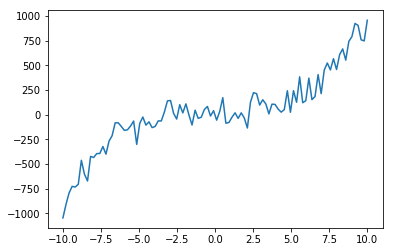

In [1]:
import torch
import torch.nn.functional as Func
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 20, std = 100)
y = x**3 + noise
plt.plot(x.data.numpy(), y.data.numpy())

In [2]:
class GaussianRegressorNLL(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, sizes, min_var = 1e-6):
        super(GaussianRegressorNLL, self).__init__()
        self.h = torch.zeros(n_input,sizes)
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.sizes = sizes
        self.layers = [self.hidden for i in range(sizes)]
        self.num_layers = sizes
    def forward(self,x):
        h = x
        output = []
        for i in range(self.num_layers):
            out = Func.relu(self.hidden(x))
            out = self.predict(out)
            output.append(out)
        mean, raw_var  = output
        var = Func.softplus(raw_var) + 1e-6
        return mean.view(-1,1), var.view(-1,1)

## Paper discussion on Score Function

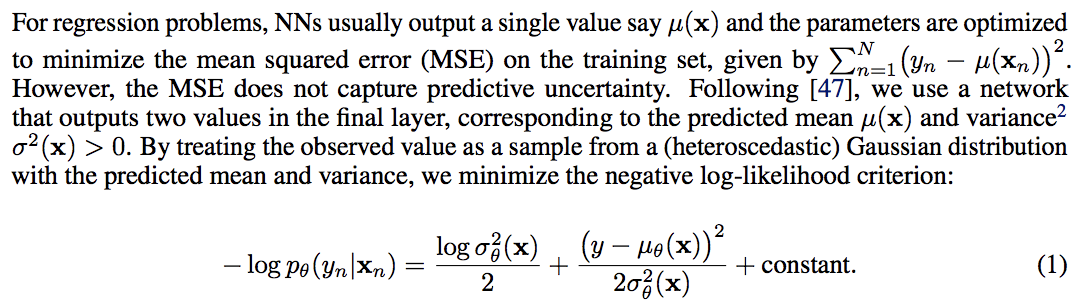

In [3]:
modelito = GaussianRegressorNLL(x.size()[0], 200, y.size()[0], sizes = 2)
modelito 

GaussianRegressorNLL(
  (hidden): Linear(in_features=100, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=100, bias=True)
)

In [7]:
mean, var = modelito(Variable(x.view(1,-1)))
mean.shape, var.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [8]:
class GaussianNLL(torch.nn.Module):
    def __init__(self):
        super(GaussianNLL,self).__init__()
    def forward(self, mean_values, var_values, y):
        error = torch.sub(y, mean_values)
        #loss =  0.5 * torch.mean(torch.log(var_values)) + 0.5 * torch.mean(torch.div(torch.mul(error,error),var_values))+ 0.5 * torch.log(2*torch.tensor(np.pi))
        loss =  0.5 * torch.mean(torch.log(var_values)) + 0.5 * torch.mean(torch.div(torch.mul(error,error),var_values))
        return loss

In [5]:
x.shape, y.shape, mean.shape, var.shape

NameError: name 'mean' is not defined

In [10]:
learning = {'mse': 0.00001,
             'nll': 0.05}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

define_loss = 'nll'
learning_rate = learning[define_loss]
loss_function = loss_dict[define_loss]
optimizer = optim.SGD(modelito.parameters(),learning_rate)

alpha = 0.1
clipping = 0.1

In [11]:
loss_function, learning_rate

(GaussianNLL(), 0.05)

In [ ]:
num_iter = 10000
for i in range(num_iter):
    preds, var = modelito(Variable(x.view(1,-1)))
    if define_loss == 'nll':
        loss = loss_function(preds, var, y)
        optimizer.step()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(modelito.parameters(), clipping)
    
    elif define_loss == 'mse':
        loss = loss_function(preds, y)
        optimizer.step()
        optimizer.zero_grad()
        loss.backward()
        #loss.register_hook(print)
        

    if i %50 ==0:
        print("Iter: {}, Loss: {}".format(i, loss.data.numpy()))
        std = np.sqrt(var.data.numpy())
        upper = preds.data.numpy() + 3 * std
        lower = preds.data.numpy() - 3 * std
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower.squeeze(), upper.squeeze(), color='yellow', alpha=0.5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 15, 'color':  'red'})
        plt.pause(0.1)
plt.ioff()
plt.show()

## Training NLL with ensemble

In [15]:
alpha = 0.1
clipping = 0.25
max_iter = 20000
K = 5  # ensemble size
eps = 1e-2

ensemble = [GaussianRegressorNLL(x.size()[0], 100, y.size()[0],2) for i in range(K)]

learning = {'mse': 0.00001,
             'nll': 0.05}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

define_loss = 'nll'
learning_rate = learning[define_loss]
loss_function = loss_dict[define_loss]



optimizer = [optim.SGD(ensemble[i].parameters(),learning_rate) for i in range(K)]
losses =[loss_function for i in range(K)]

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  # Remove the CWD from sys.path while we load stuff.


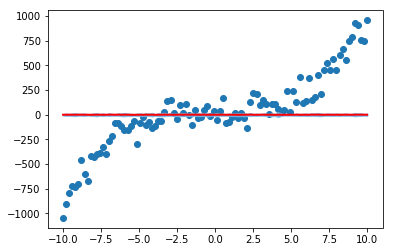

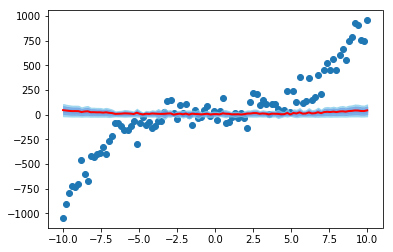

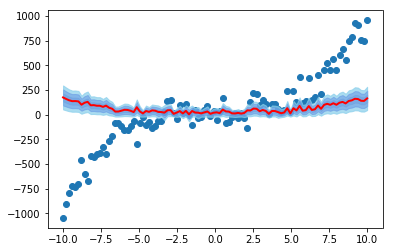

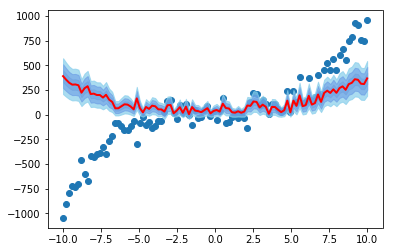

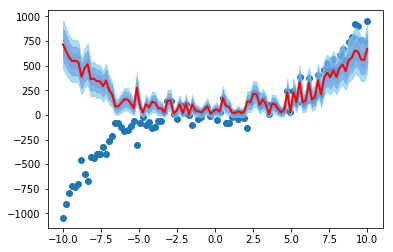

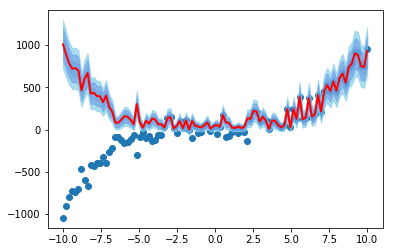

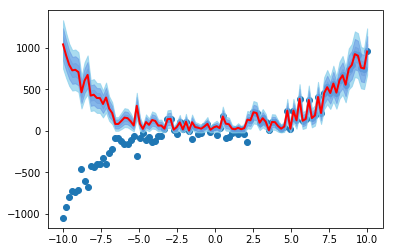

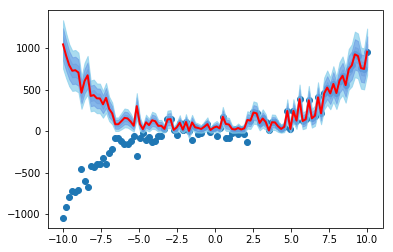

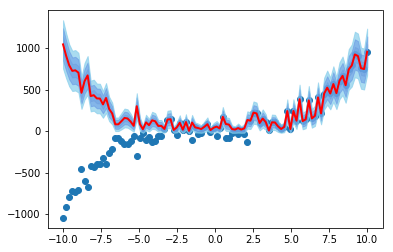

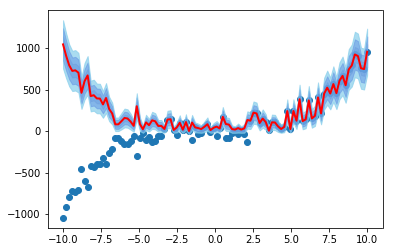

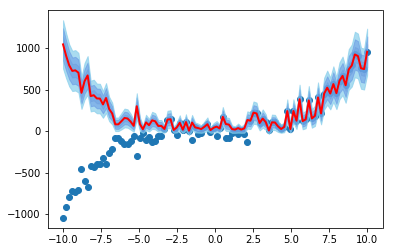

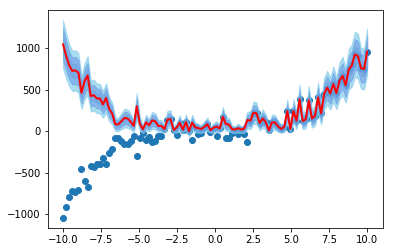

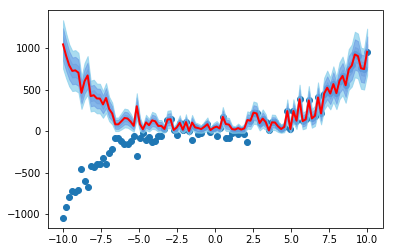

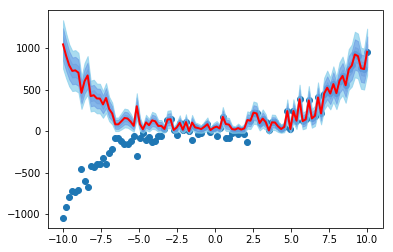

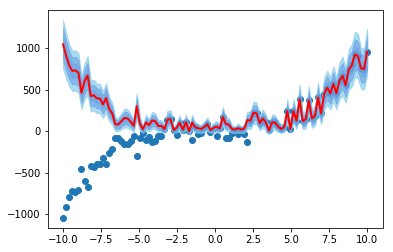

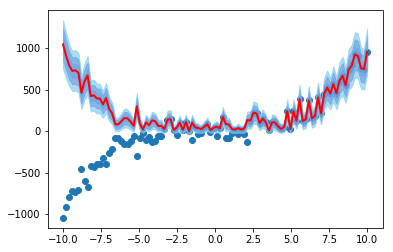

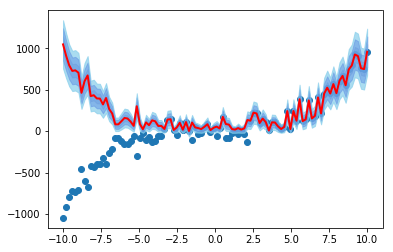

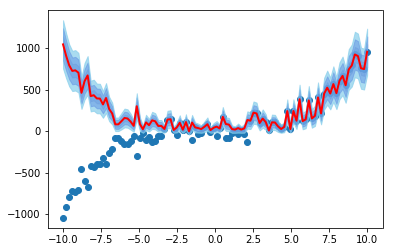

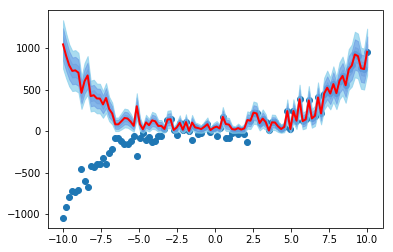

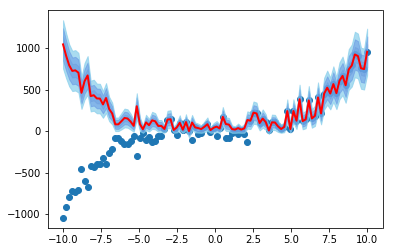

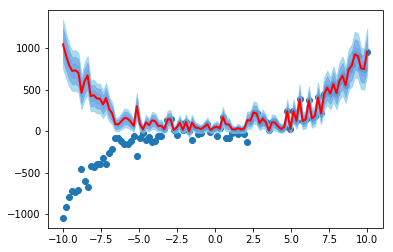

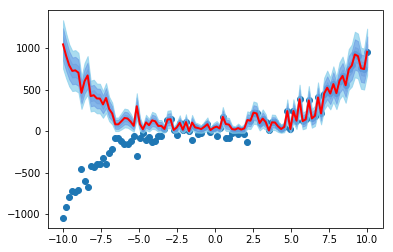

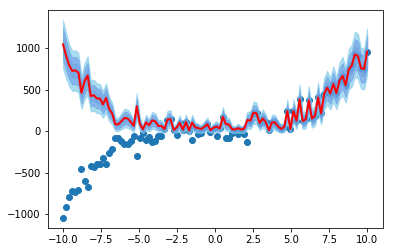

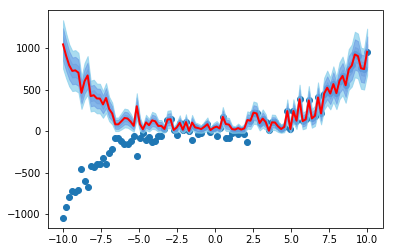

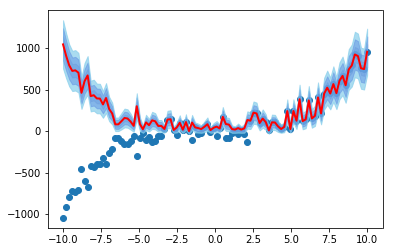

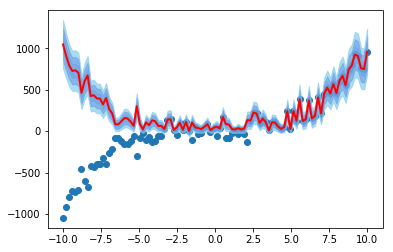

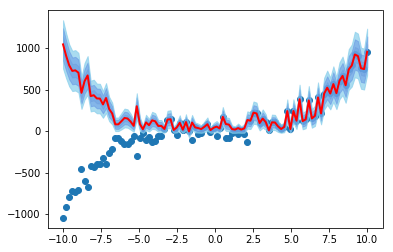

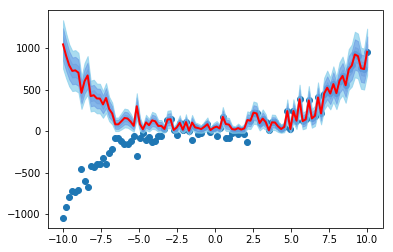

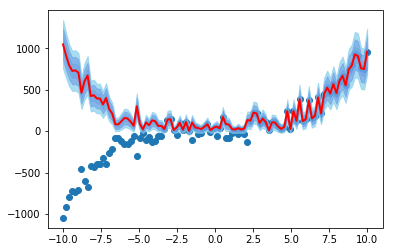

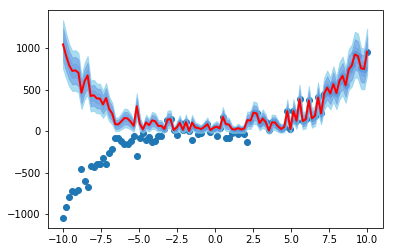

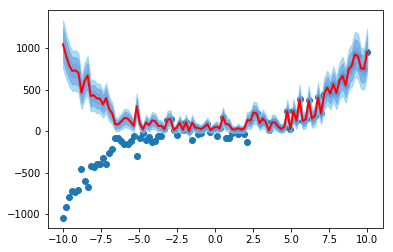

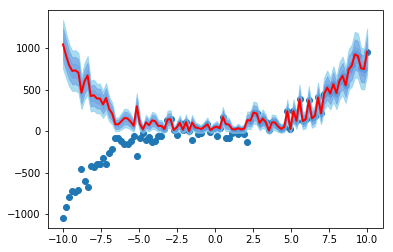

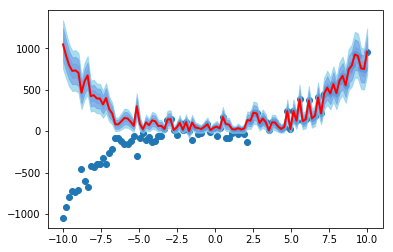

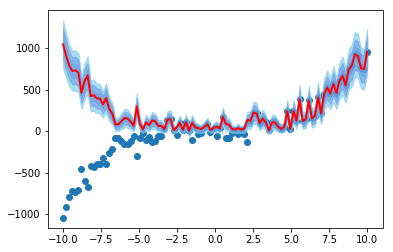

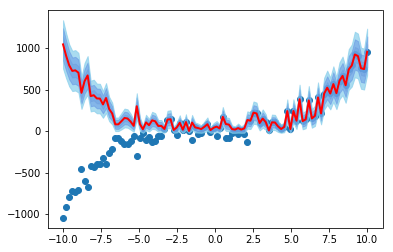

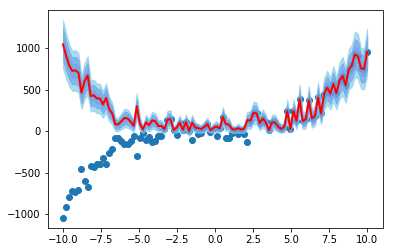

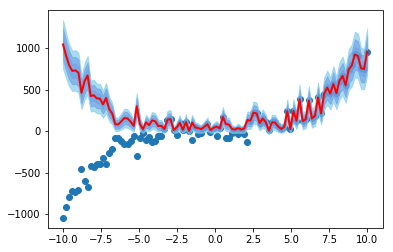

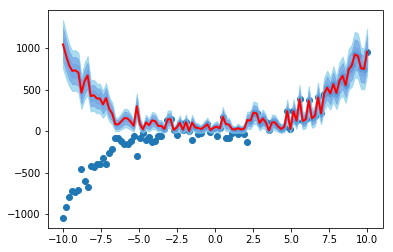

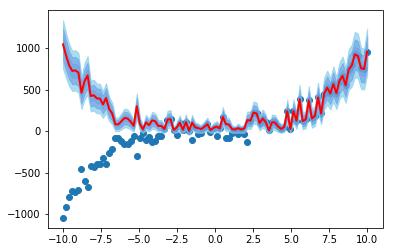

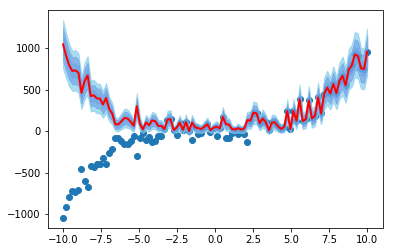

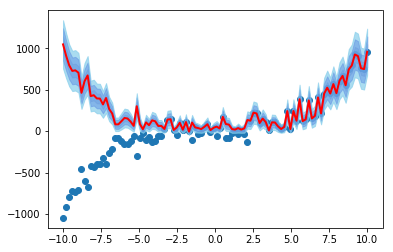

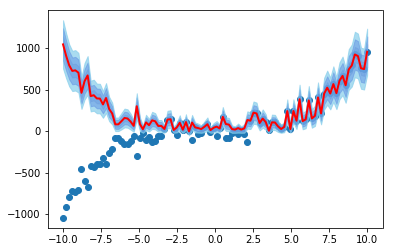

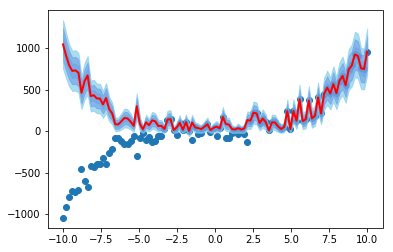

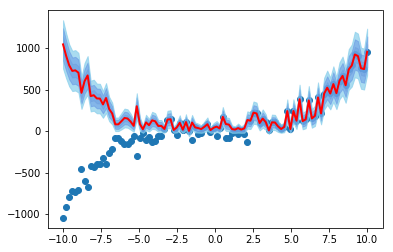

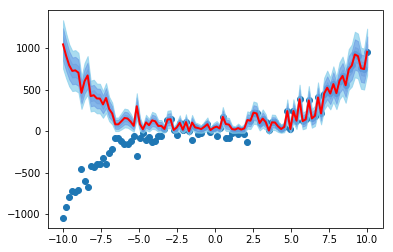

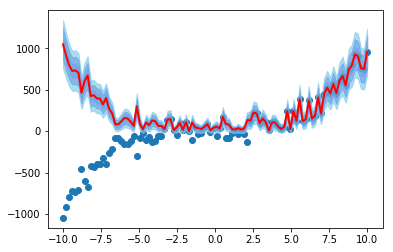

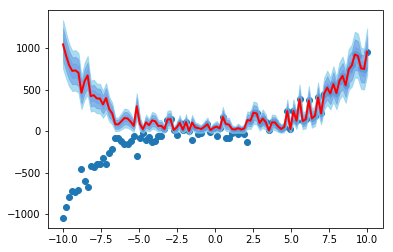

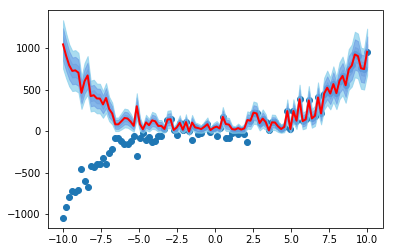

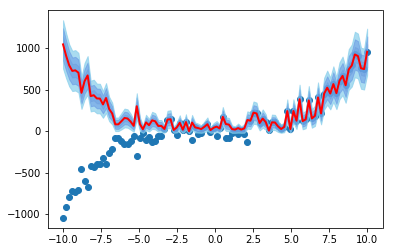

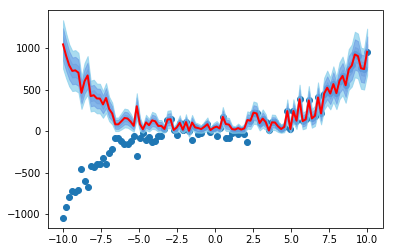

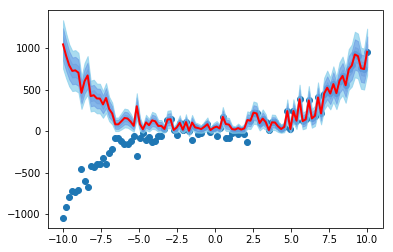

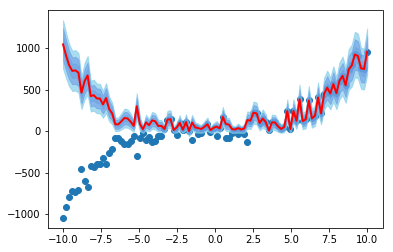

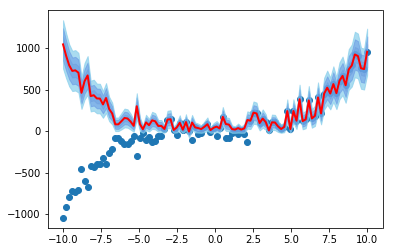

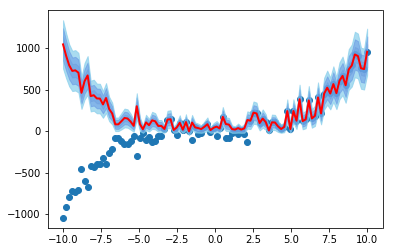

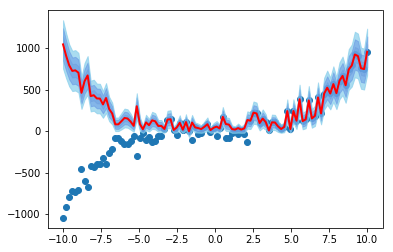

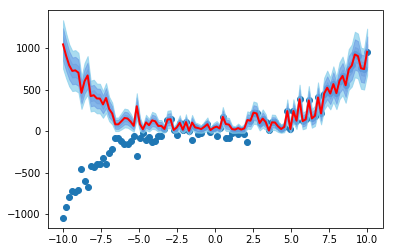

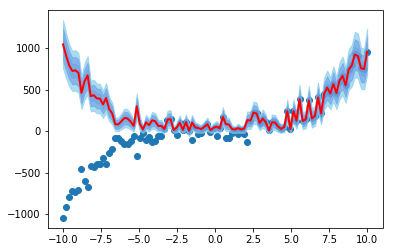

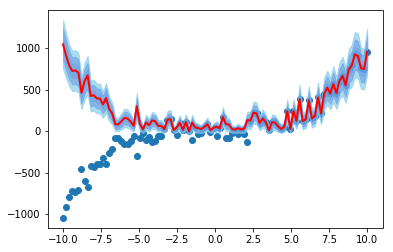

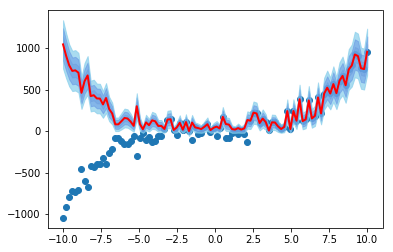

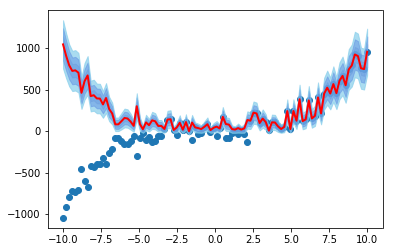

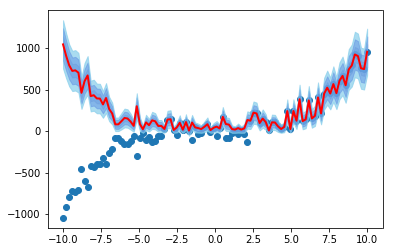

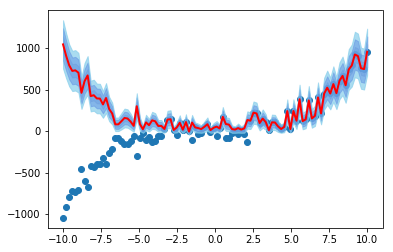

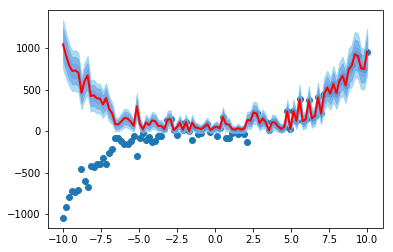

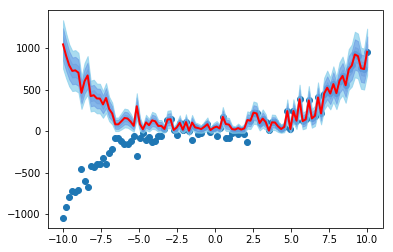

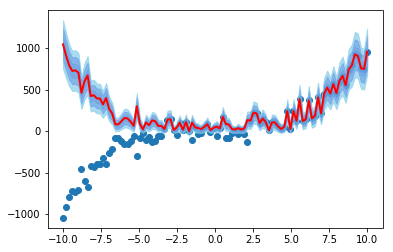

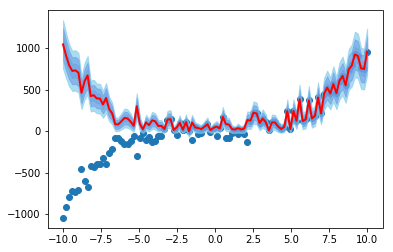

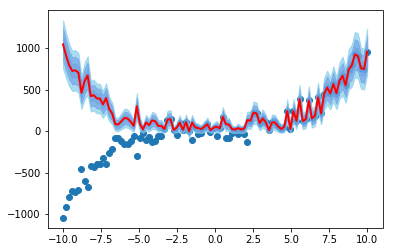

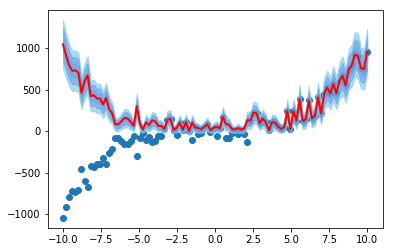

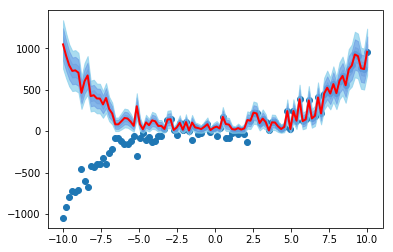

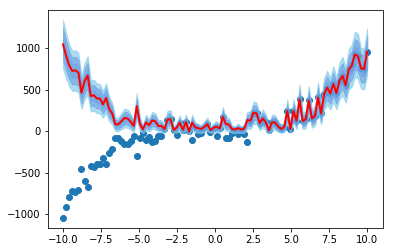

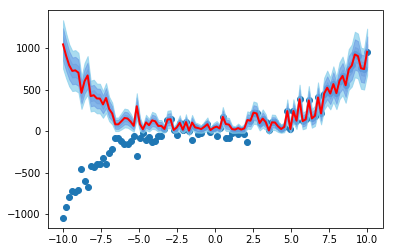

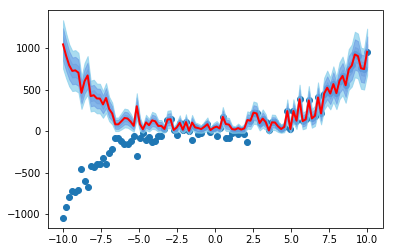

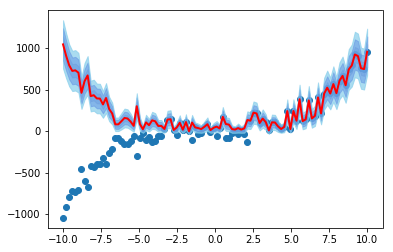

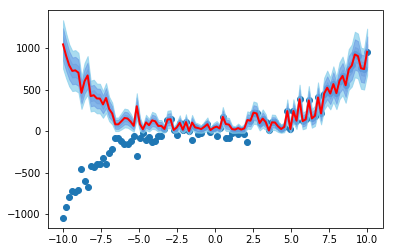

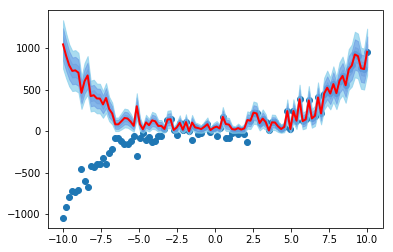

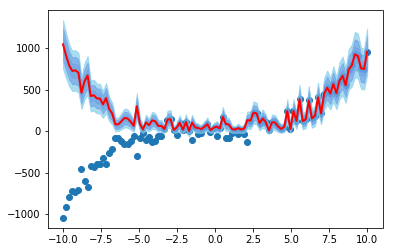

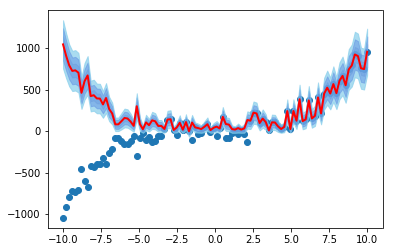

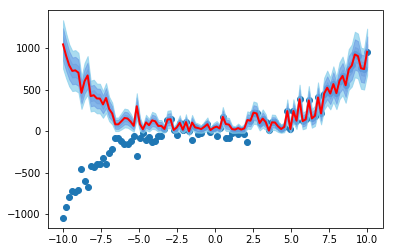

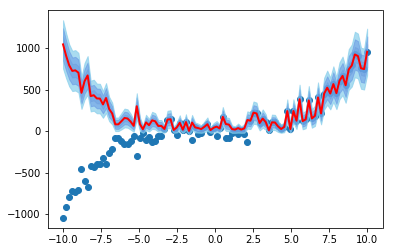

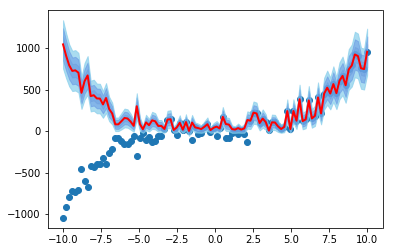

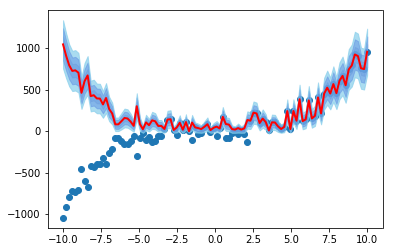

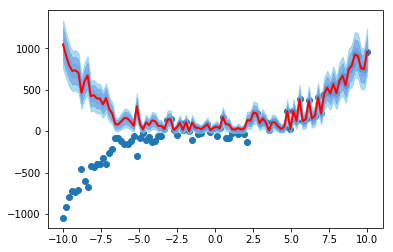

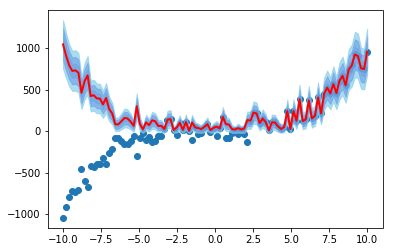

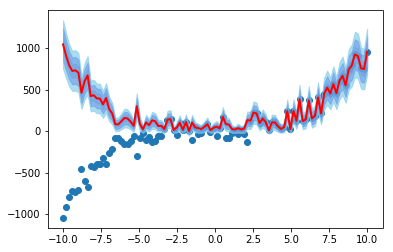

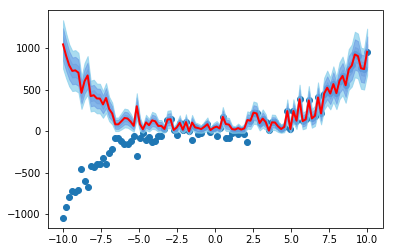

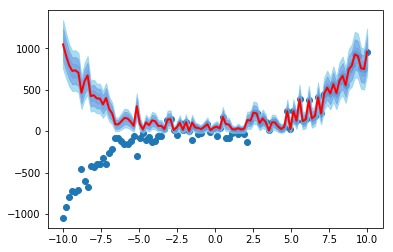

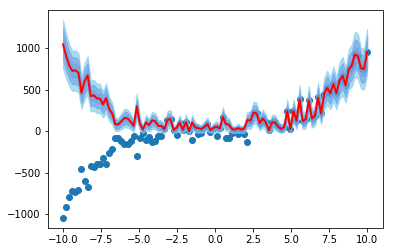

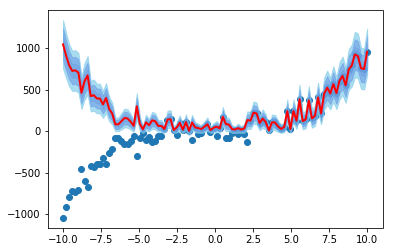

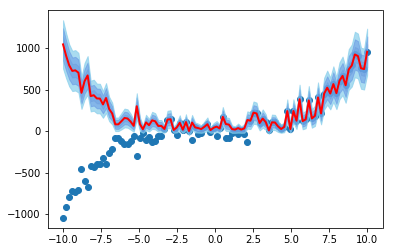

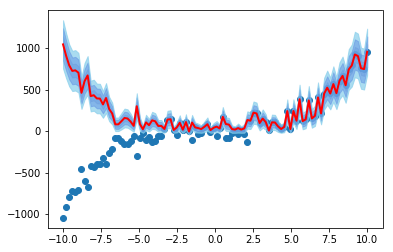

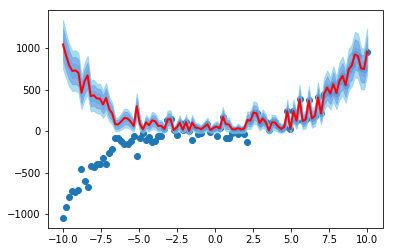

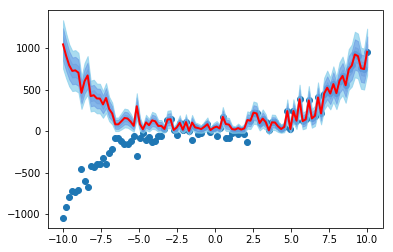

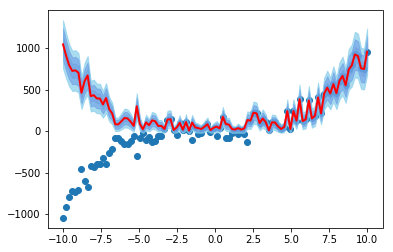

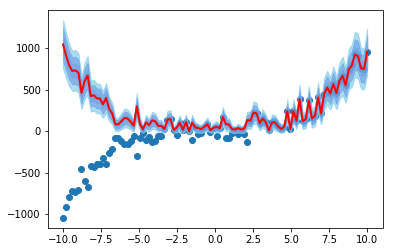

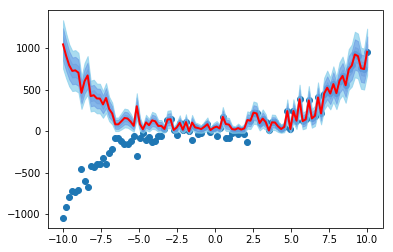

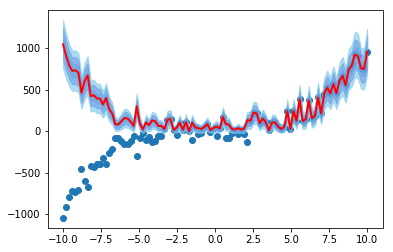

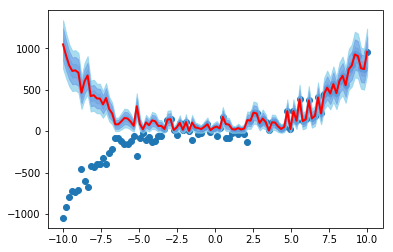

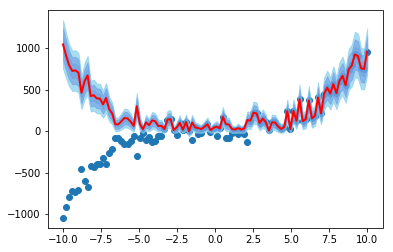

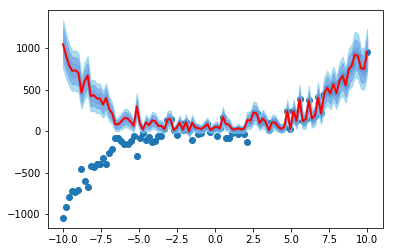

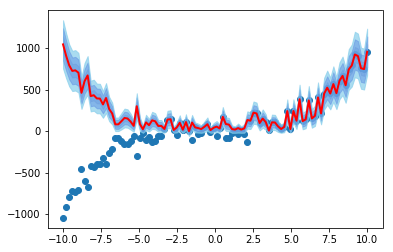

In [18]:
for i in range(max_iter):
    for model, opt, loss in zip(ensemble, optimizer, losses):
        preds, var = model(Variable(x.view(1,-1)))
        
        if define_loss == 'nll':
            loss = loss_function(preds, var, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), clipping)
    
        elif define_loss == 'mse':
            loss = loss_function(preds, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            
    if i %200 ==0:
        mean_en, var_en = mean_var_ensemble(ensemble, x)
        std = np.sqrt(var_en)
        upper_3 = mean_en + 3 * std
        lower_3 = mean_en - 3 * std
        upper_6 = mean_en + 6 * std
        lower_6 = mean_en - 6 * std
        upper_9 = mean_en + 9 * std
        lower_9 = mean_en - 9 * std
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy().squeeze(), mean_en.squeeze(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
        plt.fill_between(x.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
        plt.fill_between(x.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

        plt.pause(0.1)
plt.ioff()
plt.show()

## Chainer model

In [ ]:
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import optimizers as O
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class MLPGaussianRegressor(chainer.ChainList):

    def __init__(self, sizes):
        layers = [L.Linear(n_in, n_out)
                  for n_in, n_out in zip(sizes, sizes[1:])]
        super().__init__(*layers)

    def __call__(self, x):
        h = x
        for l in self[:-1]:
            h = F.relu(l(h))
        h = self[-1](h)
        mean, raw_var = F.split_axis(h, (1,), axis=1)
        var = F.softplus(raw_var) + 1e-6
        return mean, var

    def nll(self, x, t):
        mean, var = self(x)
        out_nll =  F.gaussian_nll(t, mean, F.log(var))
        #print("Current loss NLL: {}".format(out_nll))
        return out_nll

In [ ]:
def ensemble_mean_var(ensemble, x):
    en_mean = 0
    en_var = 0
    for model in ensemble:
        mean, var = model(x)
        en_mean += mean
        en_var += var + mean ** 2
    en_mean /= len(ensemble)
    en_var /= len(ensemble)
    en_var -= en_mean ** 2
    return en_mean, en_var

In [ ]:
K  =  5    # ensemble size# ensem 
max_iter = 10000
batchsize = 32
eps = 1e-2
alpha = 0.5
gpu = 0

ensemble = [MLPGaussianRegressor((1, 20, 20, 2)) for _ in range(K)]
optimizers = [O.Adam() for _ in range(K)]

In [ ]:
for model, opt in zip(ensemble, optimizers):
    opt.setup(model)

xp = ensemble[0].xp

In [ ]:
xs = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
noise = np.random.normal(loc=20, scale=100, size= xs.shape)
noise = np.float32(noise)
ts = xs**3 + noise
plt.plot(xs,ts)

In [ ]:
for it in range(max_iter):
    for model, opt in zip(ensemble, optimizers):
        indices = np.random.choice(np.arange(len(xs)), size=batchsize)
        x = chainer.Variable(xp.asarray(xs[indices]))
        t = chainer.Variable(xp.asarray(ts[indices]))
        # Minimize NLL for real inputs
        nll = model.nll(x, t)
        model.cleargrads()
        (alpha * nll).backward()
        # Minimize NLL for adversarial inputs
        x_prime = x + eps * xp.sign(x.grad)
        nll_at = model.nll(x_prime, t)
        ((1 - alpha) * nll_at).backward()
        opt.update()
    if it % 100 == 0:
        #print("NLL: {}, NLL_at: {}".format(nll.data,nll_at.data))
        print('Iteration: {}, NLL: {}'.format(it, nll.data))

In [ ]:
test_xs = xp.expand_dims(xp.linspace(-10, 10, num=100, dtype=np.float32), -1)
test_noise = np.random.normal(loc=20, scale=100, size= xs.shape)
test_noise = np.float32(noise)
test_ts = test_xs**3 + test_noise
mean, var = ensemble_mean_var(ensemble, test_xs)

# mean, var = ensemble[9](test_xs)
mean = chainer.cuda.to_cpu(mean.data)
var = chainer.cuda.to_cpu(var.data)
std = np.sqrt(var)
upper = mean + 3 * std
lower = mean - 3 * std
test_xs_cpu = chainer.cuda.to_cpu(test_xs)
plt.plot(test_xs_cpu, test_xs_cpu**3 + test_noise)
plt.plot(test_xs_cpu, mean)
plt.plot(test_xs_cpu, upper)
plt.plot(test_xs_cpu, lower)

## Testing both methods (Chainer and PyTorch) to see if they are outputing same loss

In [ ]:
xs = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
noise = np.random.normal(loc=20, scale=100, size= xs.shape)
noise = np.float32(noise)
ts = xs**3 + noise
plt.plot(xs,ts)

In [ ]:
xs.shape[0], ts.shape[0]

In [ ]:
## Using PyTorch model
model_torch = GaussianRegressorNLL(xs.shape[0], 200, ts.shape[0], sizes = 2)
loss_function_torch = GaussianNLL()
X = torch.tensor(Variable(torch.from_numpy(xs).view(1,-1)))
Y = torch.tensor(Variable(torch.from_numpy(ts).view(1,-1)))
preds, var = model_torch(X)
loss = loss_function_torch(preds, var, Y)
loss.data.numpy()

In [ ]:
## Using PyTorch model
model_chainer = MLPGaussianRegressor((1, xs.shape[0], ts.shape[0], 2))
loss = model_chainer.nll(xs, ts)
loss.data